In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import numpy as np
import os
from PIL import Image
import tqdm
import torch.nn.functional as F

In [2]:
# Directly inference from the trained SDM model to generate pathlogy free images
# by running the /scripts/luna16.sh under the Semantic Diffusion Model directory

# Prepare training and test dataset
LESION_PATH = "/home/user/data/gt/"
# LESION_FREE_PATH = "/home/user/data/prior_train/lesion-free"
LESION_FREE_PATH = "/home/user/data/inpainted/"
WEIGHT_MAP_PATH = "/home/user/luna-16-seg-diff-data/nodule_labels_ohe/"

class NAAImageDataset(Dataset):
  def __init__(self, lesion_path, lesion_free_path, weight_map_path):
    self.lesion_path = lesion_path
    self.lesion_free_path = lesion_free_path
    self.weight_map_path = weight_map_path
    self.file_list = os.listdir(self.lesion_path)
  
  def __len__(self):
    return len(self.file_list)
  
  def __getitem__(self, idx):
    filename = self.file_list[idx]
    lesion_image = Image.open(os.path.join(self.lesion_path, filename))
    lesion_free_image = Image.open(os.path.join(self.lesion_free_path, filename))
    
    lesion_image = lesion_image.convert('L')
    lesion_free_image = lesion_free_image.convert('L')
    
    weight_map = Image.open(os.path.join(self.weight_map_path, filename[:-4]))
    weight_map = weight_map.resize((256, 256))
    weight_map = weight_map.convert('L')
    # Convert the grayscale image to a NumPy array
    grayscale_array = np.array(weight_map)
    mask = grayscale_array > 0
    converted_array = np.where(mask, 2, 0)
    
    # Create a new image from the converted array
    # converted_image = Image.fromarray(converted_array.astype(np.uint8))
    
    return transforms.ToTensor()(lesion_image) * 255, transforms.ToTensor()(lesion_free_image) * 255, transforms.ToTensor()(converted_array)

In [39]:
dataset = NAAImageDataset(LESION_PATH, LESION_FREE_PATH, WEIGHT_MAP_PATH)

# randomly split dataset into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# create dataloaders for train and test sets
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# from torch.utils.data import DataLoader, sampler
# from torchvision import datasets, transforms

# transform = transforms.Compose([
#     transforms.ToTensor(),
# ])

# train_dat = datasets.MNIST(
#     "/home/user/Imperial-Year-4-DLCW2/data", train=True, download=True, transform=transform
# )
# test_dat = datasets.MNIST("/home/user/Imperial-Year-4-DLCW2/data", train=False, transform=transform)

# train_dataloader = DataLoader(train_dat, 32, shuffle=True, num_workers=32)
# test_dataloader = DataLoader(test_dat, 32, shuffle=False, num_workers=32)

In [75]:
# Write an autoencoder model using conv2d layers
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten()
        )

        # self.latent = nn.Sequential(
        #     nn.Linear(24 * 3 * 3, 100),
        #     nn.Linear(100, 24 * 3 * 3),
        #     nn.LeakyReLU(),
        # )

        # decoder layers
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (256, 8, 8)),
            nn.ConvTranspose2d(256, 128, 2, stride=2),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 64, 2, stride=2),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 32, 2, stride=2),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, 16, 2, stride=2),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(16, 1, 2, stride=2),
            nn.LeakyReLU(),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        # encode
        x = self.encoder(x)
        # x = self.latent(x)
        # decode
        x = self.decoder(x)
                
        return x

In [76]:
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
summary(model, input_size=(1, 256, 256))

import gc
model = model.cpu()
del model
gc.collect()
torch.cuda.empty_cache()

Total number of parameters is: 567793
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 128, 128]              80
         LeakyReLU-2          [-1, 8, 128, 128]               0
            Conv2d-3           [-1, 16, 64, 64]           1,168
         LeakyReLU-4           [-1, 16, 64, 64]               0
            Conv2d-5           [-1, 32, 32, 32]           4,640
         LeakyReLU-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 64, 16, 16]          18,496
         LeakyReLU-8           [-1, 64, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]          73,856
        LeakyReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]         295,168
        LeakyReLU-12          [-1, 256, 16, 16]               0
        MaxPool2d-13            [-1, 256, 8, 8]               0
 

In [77]:
# Write the training loop for this model
from torch import optim

def train(model, train_dataloader, test_dataloader, num_epochs=5, learning_rate=0.0001):
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    test_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for data in tqdm.tqdm(train_dataloader):
            img, lesion_free_img, weight_map = data
            img = img.to(device)
            lesion_free_img = lesion_free_img.to(device)
            weight_map = weight_map.to(device)
            # ===================forward=====================
            output = model(img)
            loss = criterion(output, img)
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        # ===================log========================
        train_loss = running_loss / len(train_dataloader)
        train_losses.append(train_loss)
        print('epoch [{}/{}], train loss:{:.4f}'.format(epoch+1, num_epochs, train_loss))
        running_loss = 0.0
        for data in tqdm.tqdm(test_dataloader):
            model.eval()
            img, lesion_free_img, weight_map = data
            img = img.to(device)
            lesion_free_img = lesion_free_img.to(device)
            weight_map = weight_map.to(device)
            # ===================forward=====================
            output = model(img)
            loss = criterion(output, img)
            running_loss += loss.item()
        # ===================log========================
        test_loss = running_loss / len(test_dataloader)
        test_losses.append(test_loss)
        print('epoch [{}/{}], test loss:{:.4f}'.format(epoch+1, num_epochs, test_loss))
    return train_losses, test_losses

model = Autoencoder().to(device)
train(model, train_dataloader, test_dataloader, num_epochs=10, learning_rate=0.0001)

100%|██████████| 29/29 [00:06<00:00,  4.18it/s]


epoch [1/10], train loss:13334.1377


100%|██████████| 8/8 [00:01<00:00,  4.80it/s]


epoch [1/10], test loss:13162.0308


100%|██████████| 29/29 [00:06<00:00,  4.30it/s]


epoch [2/10], train loss:13285.5523


100%|██████████| 8/8 [00:01<00:00,  4.77it/s]


epoch [2/10], test loss:13235.8965


100%|██████████| 29/29 [00:06<00:00,  4.28it/s]


epoch [3/10], train loss:13283.1194


100%|██████████| 8/8 [00:01<00:00,  4.86it/s]


epoch [3/10], test loss:13035.0522


100%|██████████| 29/29 [00:07<00:00,  4.00it/s]


epoch [4/10], train loss:13258.9493


100%|██████████| 8/8 [00:01<00:00,  4.88it/s]


epoch [4/10], test loss:13463.7227


100%|██████████| 29/29 [00:06<00:00,  4.38it/s]


epoch [5/10], train loss:13273.8492


100%|██████████| 8/8 [00:01<00:00,  4.78it/s]


epoch [5/10], test loss:13373.3488


100%|██████████| 29/29 [00:06<00:00,  4.35it/s]


epoch [6/10], train loss:13269.0921


100%|██████████| 8/8 [00:01<00:00,  4.92it/s]


epoch [6/10], test loss:13467.1970


100%|██████████| 29/29 [00:06<00:00,  4.36it/s]


epoch [7/10], train loss:13280.7193


100%|██████████| 8/8 [00:01<00:00,  4.91it/s]


epoch [7/10], test loss:13402.7070


100%|██████████| 29/29 [00:06<00:00,  4.33it/s]


epoch [8/10], train loss:13271.1362


100%|██████████| 8/8 [00:01<00:00,  4.92it/s]


epoch [8/10], test loss:13412.5709


100%|██████████| 29/29 [00:06<00:00,  4.36it/s]


epoch [9/10], train loss:13257.1954


100%|██████████| 8/8 [00:01<00:00,  4.94it/s]


epoch [9/10], test loss:13492.7151


100%|██████████| 29/29 [00:06<00:00,  4.38it/s]


epoch [10/10], train loss:13265.2750


100%|██████████| 8/8 [00:01<00:00,  4.88it/s]

epoch [10/10], test loss:13146.8557


([13334.137728987069,
  13285.552296605603,
  13283.119410021553,
  13258.949252424569,
  13273.849238954741,
  13269.092099946121,
  13280.719322467672,
  13271.136179956897,
  13257.195379849138,
  13265.274986530172],
 [13162.03076171875,
  13235.896484375,
  13035.05224609375,
  13463.72265625,
  13373.348754882812,
  13467.197021484375,
  13402.70703125,
  13412.570922851562,
  13492.715087890625,
  13146.855712890625])

  0%|          | 0/8 [00:00<?, ?batch/s]

0.0 255.0
0.0 255.0
0.7296083 1.0


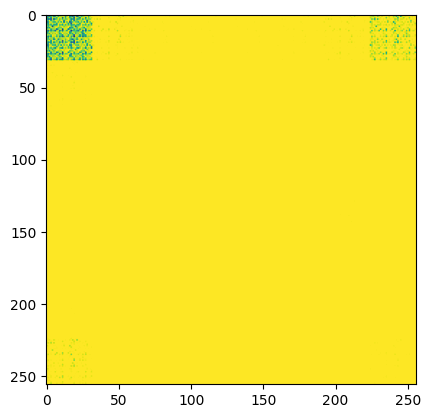

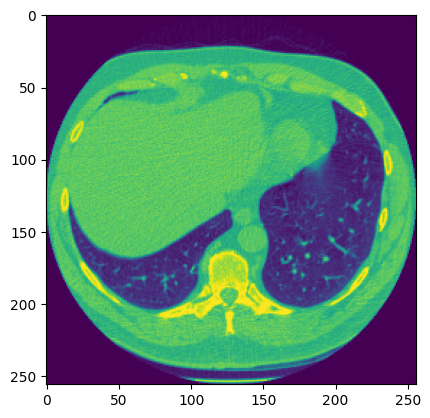

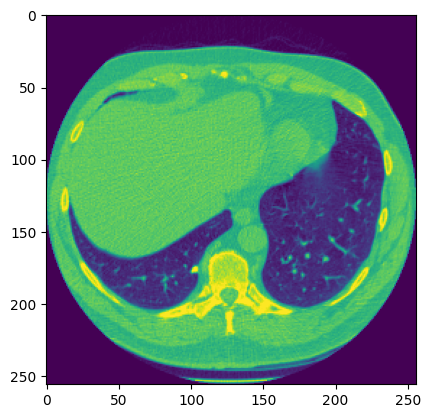

  0%|          | 0/8 [00:00<?, ?batch/s]


In [80]:
# train_losses, test_losses = train(model, train_dataloader, test_dataloader, num_epochs=5, learning_rate=1e-3)

# Plot one of the generated images
import matplotlib.pyplot as plt

model.eval()

with torch.no_grad():
  with tqdm.tqdm(test_dataloader, unit="batch") as tepoch:
    for batch_idx, (lesion, lesion_free, _) in enumerate(tepoch):
      lesion = lesion.to(device)
      # lesion_free = lesion_free.to(device)
      recon = model(lesion)
      if batch_idx % 10 == 0:
        # tepoch.set_description(f"Validation loss: {loss / len(lesion)}")
        # Define scaling factors
        big_scale = 1.01
        small_scale = 0.99

        # Scale the array
        recon = recon[0][0].cpu().numpy()
        # recon = np.where(recon > recon.mean(), recon * big_scale, recon * small_scale)
        print(lesion_free[0][0].cpu().numpy().min(), lesion_free[0][0].cpu().numpy().max())
        print(lesion[0][0].cpu().numpy().min(), lesion[0][0].cpu().numpy().max())
        print(recon.min(), recon.max())
        plt.imshow(recon)
        plt.show()
        plt.imshow(lesion_free[0][0].cpu().numpy())
        plt.show()
        plt.imshow(lesion[0][0].cpu().numpy())
        plt.show()
        break